# **Análise Exploratória de Dados de Logística - Loggi**

## 1\. Contexto

A empresa [Loggi](https://www.loggi.com/) é uma startup unicórnio brasileira de tecnologia focada em **logística**. O Loggi Benchmark for Urban Deliveries (BUD) é um repositório do GitHub ([link](https://github.com/loggi/loggibud)) com dados e códigos para problemas típicos que empresas de logística enfrentam: otimização das rotas de entrega, alocação de entregas nos veículos da frota com capacidade limitada, etc.

Este trabalho utiliza um sub conjunto dos dados originais presentes neste [link](https://github.com/loggi/loggibud/blob/master/docs/quickstart.md). O dado bruto é uma lista de instâncias de entregas. Cada instância representa um conjunto de entregas que devem ser realizadas pelos veículos do hub regional. A cidade analisada será **Brasilia**.

A análise exploratória de dados seguirá as seguintes etapas:

1.   Exploração;
2.   Manipulação;
3.   Visualização;
4.   Storytelling.

Ao final, este trabalho tem como objetivo extrair alguns insights que venha ajudar a Loggi na otimização de problemas e  melhorias nas operações de entregas.


## 2\. Pacotes e bibliotecas

In [ ]:
!pip -q install haversine
!pip3 -q install geopandas;

In [ ]:
import json
import pandas as pd
import numpy as np
from haversine import haversine
import seaborn as sns
import matplotlib.pyplot as plt
import geopy
import geopandas
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

## 3\. Exploração de dados

O dado bruto é um arquivo do tipo JSON (chave:valor) com uma lista de instâncias de entregas. Cada instância representa um conjunto de entregas que devem ser realizadas pelos veículos do hub regional. Exemplo:

```json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]


#### **3.1. Coleta de Dados**

Extração e carregamento do dataset

In [ ]:
!wget -q "https://raw.githubusercontent.com/Denesmiranda/portfolio-analista-de-dados/main/dataset/deliveries.json" -O deliveries.json

In [ ]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

In [ ]:
#Total de Instâncias
len(data)

199

In [ ]:
#Estrutura de dados (Chave) dos Hubs de distribuição
data[0].keys()

dict_keys(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'])

In [ ]:
#Etrutura de dados (Chave) dos pontos das entregas
data[0]['deliveries'][0].keys()

dict_keys(['id', 'point', 'size'])

### **3.2. Data Wrangling**

 Inicio da transformação e manipulação dos dados brutos em saídas estruturada para análise e geração de informações úteis.

In [ ]:
#Construindo um DataDrame Pandas a partir dos dados brutos estruturados no formato Json
deliveries_df = pd.DataFrame(data)
deliveries_df.head(3)

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."


Os dados das colunas **origin** e **deliveries** estão aninhados na estrutura  do JSON.

**Coluna Origin**

Será utilizado o método json_normalize para transformar cada chave em uma nova coluna.

In [ ]:
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df.head(3)

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145


In [ ]:
#Juntando os dados das colunas: lng e lat (normalizado) ao conjunto de dados principal (deliveries_df) mantendo o índice original
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df.head(3)

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145


In [ ]:
#Removendo a coluna antiga 'origin'
deliveries_df = deliveries_df.drop("origin", axis=1)

 #Renomeando as colunas lng e lat com novas identificações
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

#Reordenando as novas colunas do conunto de dados principal
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "vehicle_capacity", "deliveries"]]

In [ ]:
deliveries_df.head(3 ) #Visualização do conjunto final

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."


**Coluna deliveries**

Será utilizado o método explode que transformará cada elemento da lista em uma linha.

In [ ]:
#Aplicando o método
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df.head(3)

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."


In [ ]:
#Aplicando o método e extraindo os dados: size, point lng e point lat. id será desconsiderado para essa análise.
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_normalized_df.head(3)

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871


In [ ]:
#Tamanho da base principal (deliveries_df)
len(deliveries_df)

199

In [ ]:
#Tamanho da base normalizada (deliveries_normalized_df)
len(deliveries_exploded_df)

636149

In [ ]:
#Juntando os dataframes 'deliveries_df' e 'deliveries_normalized_df'
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

In [ ]:
#Removendo a coluna antiga 'deliveries'
deliveries_df = deliveries_df.drop("deliveries", axis=1)

In [ ]:
#Visualizando o DataFrame final
deliveries_df.head(3)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871


In [ ]:
#Tamanho final do conjunto principal
len(deliveries_df)

636149

### **3.3. Estrutura**

Com o DataFrame devidamente estruturado o processo agora é da verificação da consistência dos dados.

In [ ]:
#Verificando a quantidade de registro e colunas
deliveries_df.shape

(636149, 8)

In [ ]:
#Verificando se todas as colunas construidas estão presentes
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [ ]:
#Verificando os índices
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [ ]:
#Estrutura do DataFrame
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


### **3.4. Schema**

In [ ]:
#Tipagem dos Dados
deliveries_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

In [ ]:
#Descrição estatística dos atributos categóricos
deliveries_df.select_dtypes('object').describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [ ]:
#Descrição estatística dos atributos númericos
deliveries_df.select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


### **3.5. Dados faltantes**

In [ ]:
#Veificando a presença de Dados nulos
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

## 4\. Manipulação

### **4.1. Enriquecimento**

**Geocodificação reversa do hub**

Geocodificação reversa do hub será transformado uma coordenada geográfica de um local em suas respectivas descrições textuais.

In [ ]:
#Total de Hubs
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Será utilizado o pacote geopy para enriquecer o DataFrame principal.

In [ ]:
geolocator = Nominatim(user_agent="denes_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 13551965,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.10000999999999993,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "stat

In [ ]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


Aplicação da geocodificação nas coordenadas das três regiões e extrair informações de **cidade** e **bairro**.

In [ ]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,13551965,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN
1,13548034,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,10766946,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.00001,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [ ]:
#Selecionando as colunas de interesse
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


Enriquecimento do DataFrame principal com os dados DataFrame hub_geodata_df contendo cidade e bairro.

In [ ]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


**Geocodificação reversa da entrega**

In [ ]:
#Extraindo a lista processada contendo as intâncias de entregas geocoficada
!wget -q "https://raw.githubusercontent.com/Denesmiranda/portfolio-analista-de-dados/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [ ]:
#Carregando o conjunto de dados
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
#Juntando o DataFrame deliveries_geodata_df ao DataFrame principal
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


**Calculando distância entre Hub e ponto de entrega**

In [ ]:
#Calcular a distância de latitude e longitude entre 2 pontos
def calcula_lat_lng(lat_a, lng_a, lat_b, lng_b):
    point_a = (lat_a, lng_a)
    point_b = (lat_b, lng_b)

    return round(haversine(point_a, point_b, unit='km'), 2)


# Construindo a coluna de distância no dataframe
lng1 = deliveries_df['hub_lng']
lat1 = deliveries_df['hub_lat']
lng2 = deliveries_df['delivery_lng']
lat2 = deliveries_df['delivery_lat']

distance = []
for lng_a, lng_b, lat_a, lat_b in zip(lng1, lng2, lat1, lat2):
  x = calcula_lat_lng(lat_a, lng_a, lat_b, lng_b)
  distance.append(x)

deliveries_df['delivery_distance(km)'] = distance

deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,delivery_distance(km)
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.66
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.91
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.24
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.81
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.78


### **4.2. Qualidade dos Dados**

Verificando a qualidade dos dados, schema, valores faltantes, etc.

In [ ]:
deliveries_df[['delivery_distance(km)']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
delivery_distance(km),636149.0,7.09505,5.34192,0.0,3.68,5.53,8.89,67.92


In [ ]:
#Estrutura do DataFrame
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   name                   636149 non-null  object 
 1   region                 636149 non-null  object 
 2   hub_lng                636149 non-null  float64
 3   hub_lat                636149 non-null  float64
 4   hub_city               636149 non-null  object 
 5   hub_suburb             636149 non-null  object 
 6   vehicle_capacity       636149 non-null  int64  
 7   delivery_size          636149 non-null  int64  
 8   delivery_lng           636149 non-null  float64
 9   delivery_lat           636149 non-null  float64
 10  delivery_city          634447 non-null  object 
 11  delivery_suburb        476264 non-null  object 
 12  delivery_distance(km)  636149 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 84.1+ MB


In [ ]:
#Verificando a existência de valores nulos
deliveries_df.isna().any()

name                     False
region                   False
hub_lng                  False
hub_lat                  False
hub_city                 False
hub_suburb               False
vehicle_capacity         False
delivery_size            False
delivery_lng             False
delivery_lat             False
delivery_city             True
delivery_suburb           True
delivery_distance(km)    False
dtype: bool

- **Geocodificação reversa**

In [ ]:
print(f'delivery_city - (%) de valores nulos: {100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))}')

delivery_city - (%) de valores nulos: 0.26754738276724477


In [ ]:
print(f'delivery_suburb - (%) de valores nulos: {100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))}')

delivery_suburb - (%) de valores nulos: 25.133262804783158


In [ ]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
dtype: float64

In [ ]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
dtype: float64

**Nota:** A geocodificação tem suas limitações e pode impactar na qualidade final dos resultados. O que demonstrou nos resultados acima a categorização errada de Brasilia como bairro criando uma distorção no DataFrame.


## 5\. Visualização de Dados

Com o os dados estruturas o DataFrame esta pronto para iniciar as analises, extrair insights e construir visões através de mapas.<br>

### **5.1. Análises**

 **Mapa do Distrito Federal**

In [ ]:
# Download dos dados do mapa do Distrito Federal do site oficial do IBGE através do seguinte link para criar o DataFrame mapa.
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [ ]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


 **Mapa dos Hubs**

In [ ]:
#Criando o DataFrame geo_hub_df através do DataFrame deliveries_df com a nova coluna geometry.
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


 **Mapa das Entregas**

In [ ]:
#Criando o DataFrame geo_deliveries_df através do DataFrame deliveries_df com a nova coluna geometry.
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,delivery_distance(km),geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.66,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.91,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.24,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.81,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.78,POINT (-48.11490 -15.85805)


### **5.1. Mapa de entregas por região**

<ipython-input-52-cf880fc64793>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


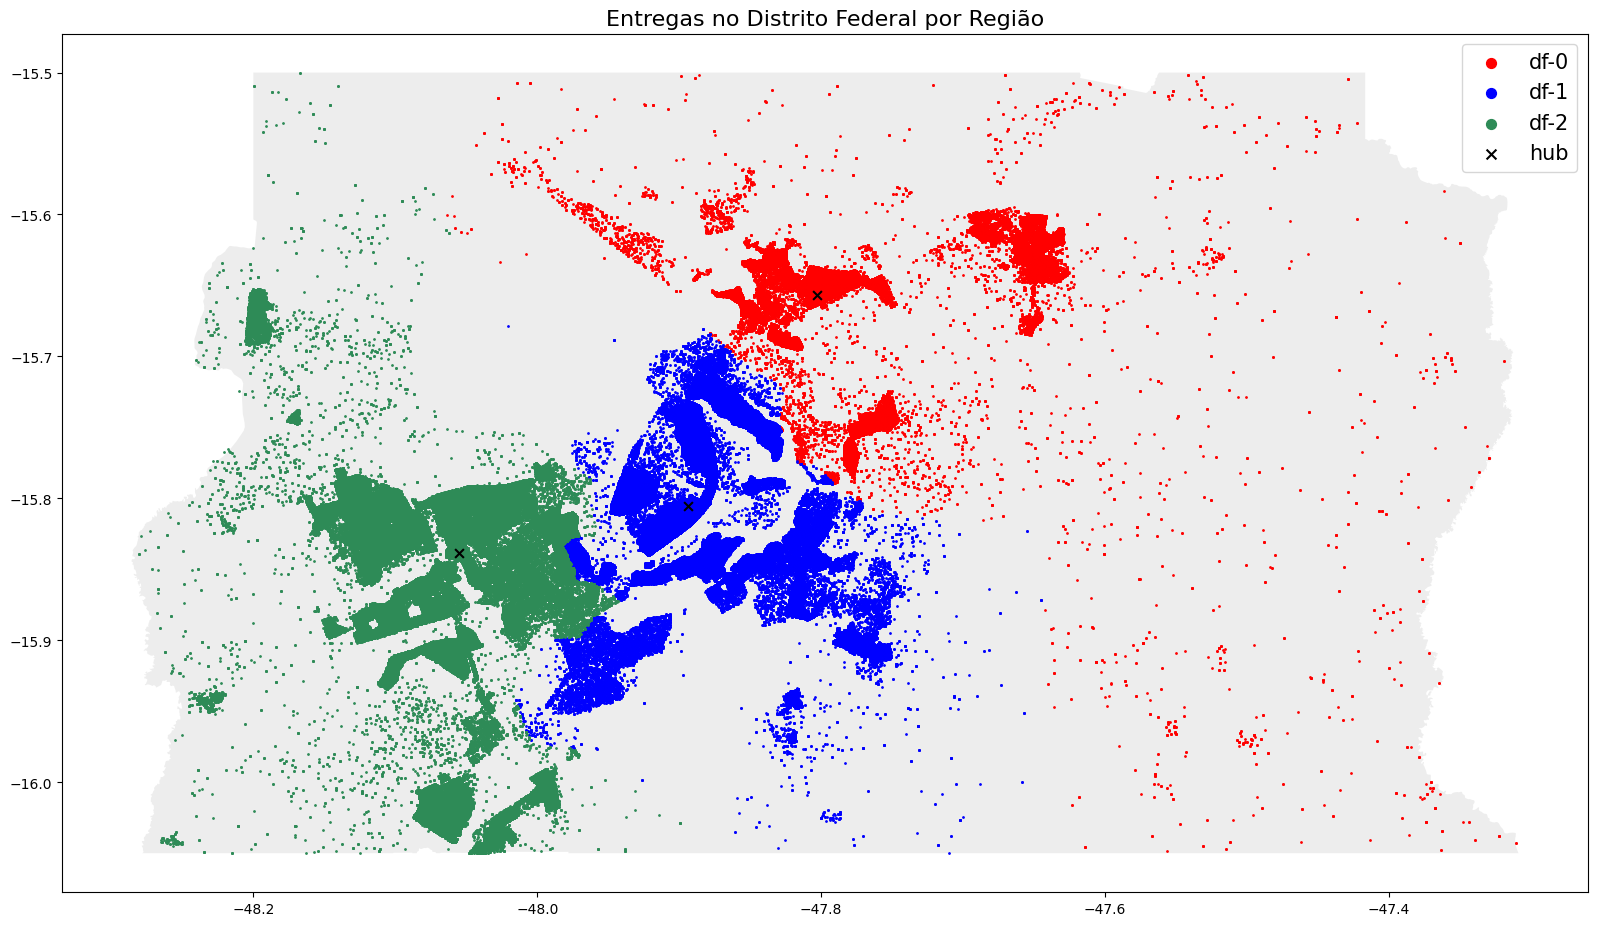

In [ ]:
#cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=40, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

**INSIGHT 1**<br>
Os Hubs estão bem localizados em regiões estratégicas quando comparado aos pontos de entrega, porém há alguns pontos a serem destacados:

**df-0:** é o ponto com maior dispersão o que impacta diretamente nos prazos das entregas, planejamento de rotas com maior complexidade e consequentemente custos operacionais logísticos.

**df-1:** tem maior concentração de pontos de entregas o que sugere rotas melhor planejada impactando diretamente na operação da entrega sendo menos propenso a atrasos, já que não há muita dispersão de distância.

**df-2:** possuem pontos de concentração, porém abrange uma área de dispersão bastante elevada em relação ao Hub central o que pode gerar dificuldade no planejamento e maior tempo logístico.




### **5.2. Gráfico de entregas por região**

In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


<ipython-input-54-1649afbc4b6d>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")


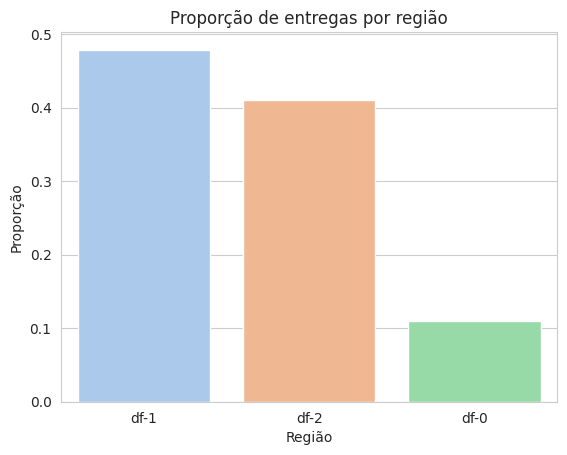

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

**INSIGHT 2**<br>
A capacidade operacional de carga é igual para as regiões **df-0, df-1 e df-2**. Quanto maior a concentração, maior o volume de entrega e de maneira contraria, quanto mais distante o ponto de entrega, menor o volume de entrega.

Um planejamento de rota seria viável para realocação de transporte atendendo áreas com maior volume de entrega e assim reduzir tempo e custo.
Para a região **df-0**, cabe uma analise de viabilidade operacional junto com uma estratégia comercial e de marketing, visando o aumento do volume das vendas próximo ao Hub, assim seria possível o aumento da receita e custeio das regiões mais distantes,  evitando o encerramento de rotas.


### **5.3 Gráfico de Distância de Entregas por Região**

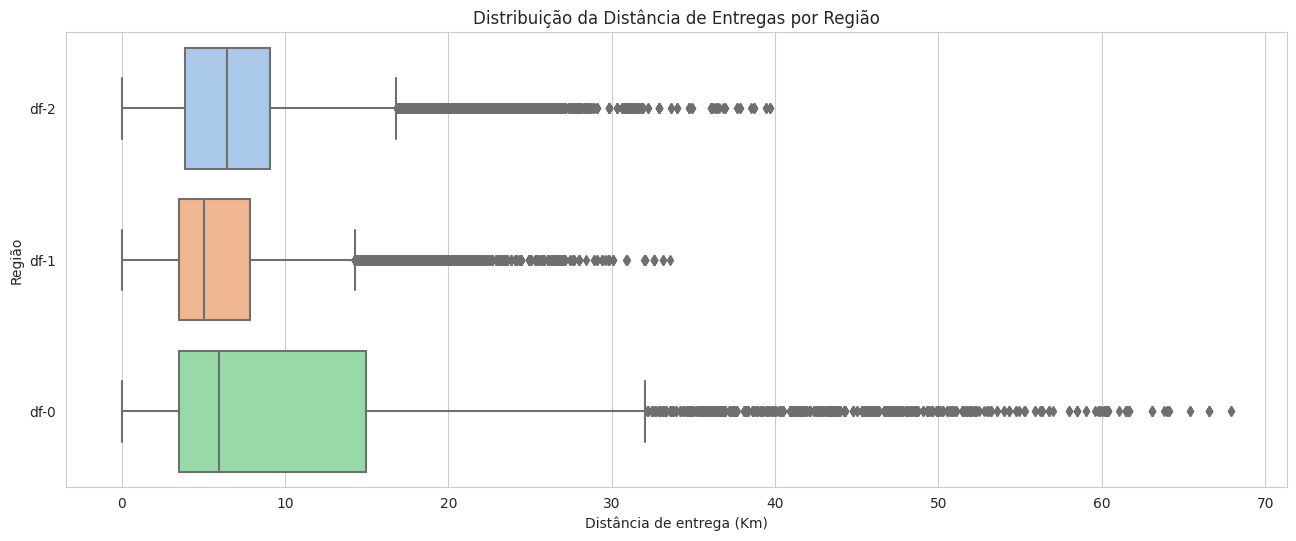

In [ ]:
with sns.axes_style('whitegrid'):
  boxplot_graphic = sns.boxplot(x=deliveries_df['delivery_distance(km)'], y=deliveries_df['region'], palette="pastel")
  boxplot_graphic.set(title='Distribuição da Distância de Entregas por Região', xlabel='Distância de entrega (Km)', ylabel='Região')
  boxplot_graphic.figure.set_size_inches(w=40/2.54, h=15/2.54)

**INSIGHT 3**<br>

Podemos observar que os 03 Hubs apresentam outliers (dados discrepantes) sendo a região região df-0 com maior presença. Um planejamento logistico alinhado com estratégias comerciais para o aumento da capacidade de clientes, e a viabilidade operacional para a criação de hub adicional adjcente operando com uma malha de transporte menor, pode trazer resultados no ganho na velocidade de entrega bem como a otimização de custos.

Um outro dado importante e não presente no conjunto de dados é entender a frequência de entrega desses pontos isolados. Eles estão presentes na malha de distribuição demonstrando amplitude de cobertura em áreas remotas. Portanto, ficou faltando o entendimento sobre qual o critério para abertura ou encerramento de um ponto de entrega.
